In [1]:
from fastai.text.all import *

In [2]:
from torch.utils.data import Dataset

In [3]:
class TwinSequence(Dataset):
    def __init__(self, sl=1024, len=100):
        assert sl%2 == 0
        self.sl = sl
        self.len = len
    def __getitem__(self, idx):
        seq = torch.randint(1,127,(self.sl//2,))
        seq[0] = 0
        return (torch.cat((seq,seq), -1),)
    def __len__(self):
        return self.len

Training with sl = 1024 didn't work. Need to find a way to trigger "phase transition" (see below)

Things to try:
- Large batch size
- Use another learning rate schedule instead of `fit_one_cycle`. Mb warmup followed with plain lr...

See training on shorter sequence. It has no progress for some time and the jumps to low loss fast, but it then takes more time to reach 100% accuracy (or mb not, try increasing validation set size) and doesn't reach 0 loss.

In [4]:
sl = 1024
train_sz = 50000
valid_sz = 1000
dls = DataLoaders.from_dsets(TwinSequence(sl, train_sz), TwinSequence(sl, valid_sz), bs=16, shuffle=False, device='cuda')

In [5]:
from basic_transformer import TransformerLM

In [6]:
class MakeTargCallback(Callback):
    def before_batch(self):
        y = self.x.clone()
        y[:, :self.dls.train_ds.sl//2 + 1] = -100
        self.learn.xb = (self.x[:, :-1], )
        self.learn.yb = (y[:, 1:],)

In [7]:
def masked_accuracy(inp, targ, ignore=-100):
    pred = inp.argmax(dim=-1)
    mask = targ[0] != ignore
    return (pred[:,mask] == targ[:,mask]).float().mean()

In [8]:
model = TransformerLM(128, 256, d_ff=256, depth=1, heads=4, max_seq_len=sl, pos_enc='fixed',
                      attn_dropout=0, ff_dropout=0, emb_dropout=0)

In [9]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=masked_accuracy, cbs=[MakeTargCallback()])

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.0008317637839354575)

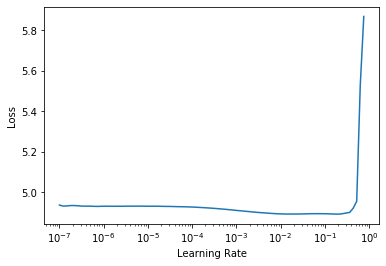

In [10]:
learn.lr_find()

In [11]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,masked_accuracy,time
0,4.836637,4.836576,0.008139,03:22
1,4.836359,4.836336,0.007986,03:22
2,4.836286,4.836298,0.007824,03:23


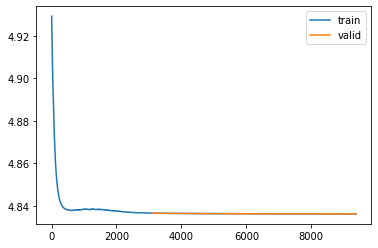

In [12]:
learn.recorder.plot_loss()

## Shorter sequence + Attention visualization

In [33]:
sl = 64#1024
train_sz = 50000
valid_sz = 1000
dls = DataLoaders.from_dsets(TwinSequence(sl, train_sz), TwinSequence(sl, valid_sz), bs=100, shuffle=False, device='cuda')

In [34]:
learn = Learner(dls, TransformerLM(128, 256, d_ff=256, depth=1, heads=4, max_seq_len=sl, pos_enc='fixed',
                                   attn_dropout=0, ff_dropout=0, emb_dropout=0), 
                loss_func=CrossEntropyLossFlat(), metrics=masked_accuracy, cbs=[MakeTargCallback()])

In [35]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,masked_accuracy,time
0,0.026967,0.008249,0.998807,00:10
1,0.001406,0.001276,0.999774,00:10
2,0.000265,0.000239,1.000000,00:10


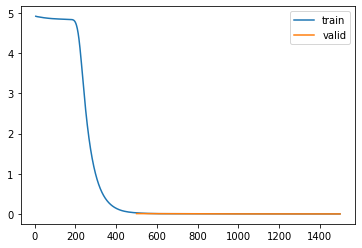

In [36]:
learn.recorder.plot_loss()

In [43]:
x = dls.train_ds[0][0].cuda()
x = x[None]
x[:,x.size(1)//2+1:]

tensor([[  8,  93,  29,   7,  37,  39,  21,  83,  94,  34, 119, 118,  77,  51,
         122,  96,  75,  55,  69,  13,   6, 123,  16,  11,  18,  80,  25,  14,
         123,   1,  27]], device='cuda:0')

In [44]:
learn.model.store_attention()

In [45]:
with torch.no_grad():
    out = learn.model(x[:,:-1])

In [46]:
out.argmax(-1)[:,x.size(1)//2:]

tensor([[  8,  93,  29,   7,  37,  39,  21,  83,  94,  34, 119, 118,  77,  51,
         122,  96,  75,  55,  69,  13,   6, 123,  16,  11,  18,  80,  25,  14,
         123,   1,  27]], device='cuda:0')

In [47]:
attn = learn.model.get_attention_matrix()

In [48]:
attn[0].shape

torch.Size([1, 4, 63, 63])

Q: Why is attention in the first part grouped towards the begining but not distributed evenly?

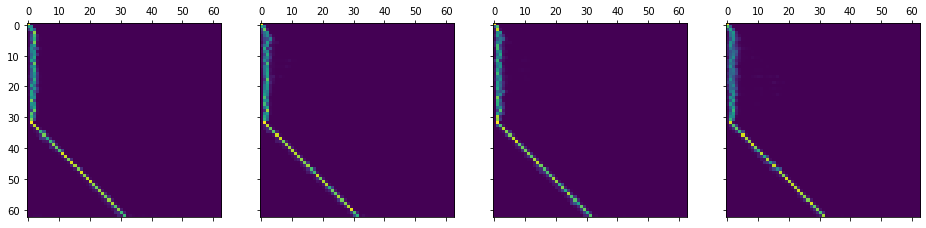

In [49]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(16, 16))
for ax, mat in zip(axs, attn[0][0]):
    ax.matshow(mat)

### Single head

In [50]:
model = TransformerLM(128, 256, d_ff=256, depth=1, heads=1, max_seq_len=1024, pos_enc='fixed',
                      attn_dropout=0, ff_dropout=0, emb_dropout=0)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=masked_accuracy, cbs=[MakeTargCallback()])

In [51]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,masked_accuracy,time
0,0.024288,0.010525,0.998129,00:10
1,0.001803,0.000899,0.999903,00:09
2,0.000365,0.000337,1.000000,00:09


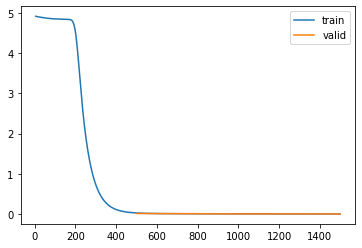

In [52]:
learn.recorder.plot_loss()

In [53]:
learn.model.store_attention()

In [54]:
x = dls.train_ds[0][0].cuda()
x = x[None]
with torch.no_grad():
    out = learn.model(x)

In [55]:
attn = learn.model.get_attention_matrix()

In [56]:
attn[0].shape

torch.Size([1, 1, 64, 64])

In [57]:
attn[0][0,0].shape

torch.Size([64, 64])

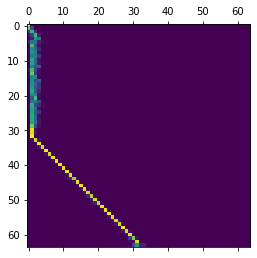

In [58]:
plt.matshow(attn[0][0,0])